# Lab 4: Working with 'real' data



In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r') #Import the file

In [3]:
hf.keys() # Look at the header

<KeysViewHDF5 ['data']>

In [4]:
# data = np.array(hf.get('data')) # import the data into an array variable using the get method

In [5]:
hf.close() # Close the file

## Problem 1

*Create a feew plot generally exploring your data*

In [6]:
hf = h5py.File('gammaray_lab4.h5', 'r') #Import the file
data = np.array(hf.get('data'))

In [7]:
def makePlot(x, y, start, end, step = 1):
    
    plt.plot(x[int(start):int(end):int(step)], y[int(start):int(end):int(step)])
    plt.tick_params(labelsize = 24)

In [8]:
time = data[0,:]
solarPhase = data[1,:]
long = data[2,:]
counts = data[3,:]

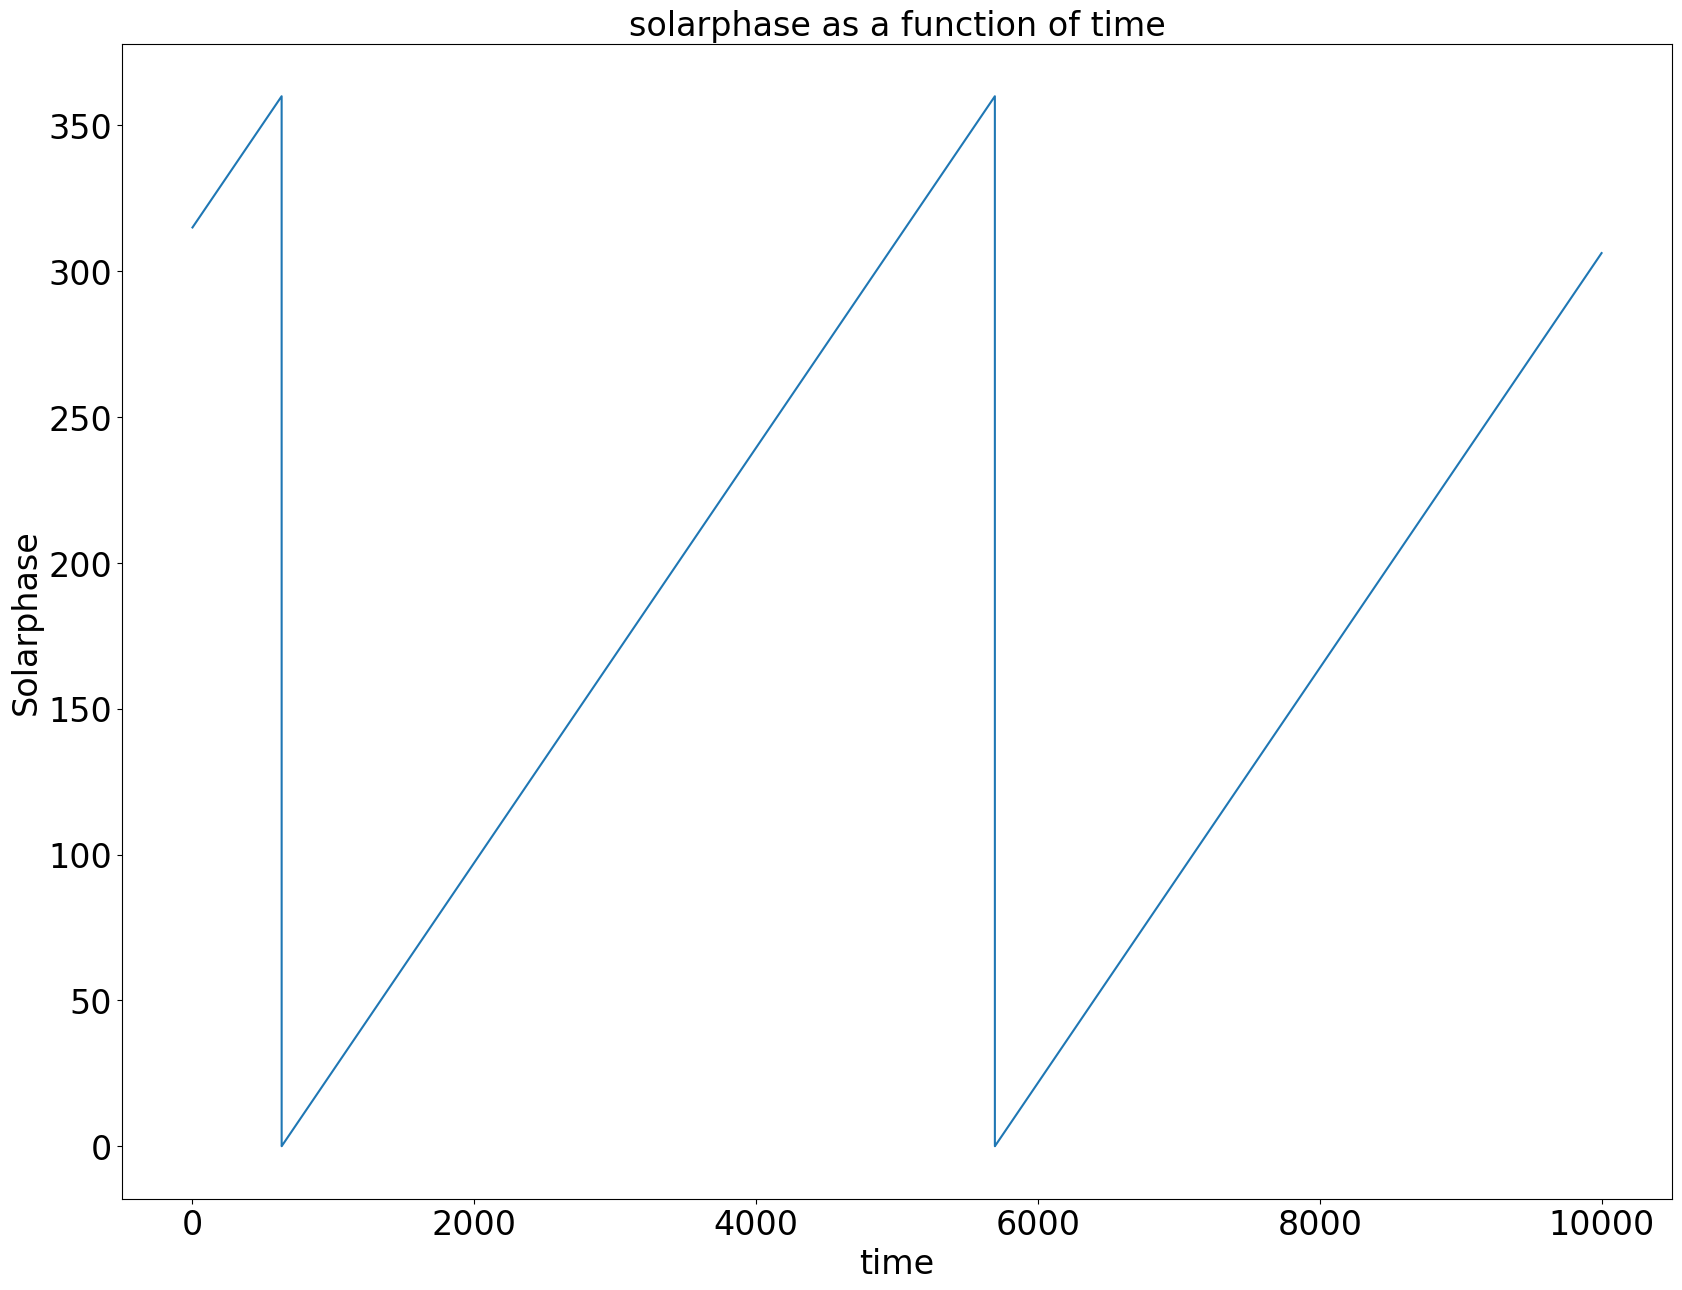

In [9]:

makePlot(time-time[0], solarPhase, 0, 100000, 1)
plt.xlabel("time", fontsize = 24)
plt.ylabel("Solarphase", fontsize = 24)
plt.title("solarphase as a function of time", fontsize = 24);

The above plot shows the solar phase as a function of time for the first 100,000 data points. From this we can see that the satellite is orbiting the sun at a constant rate. 

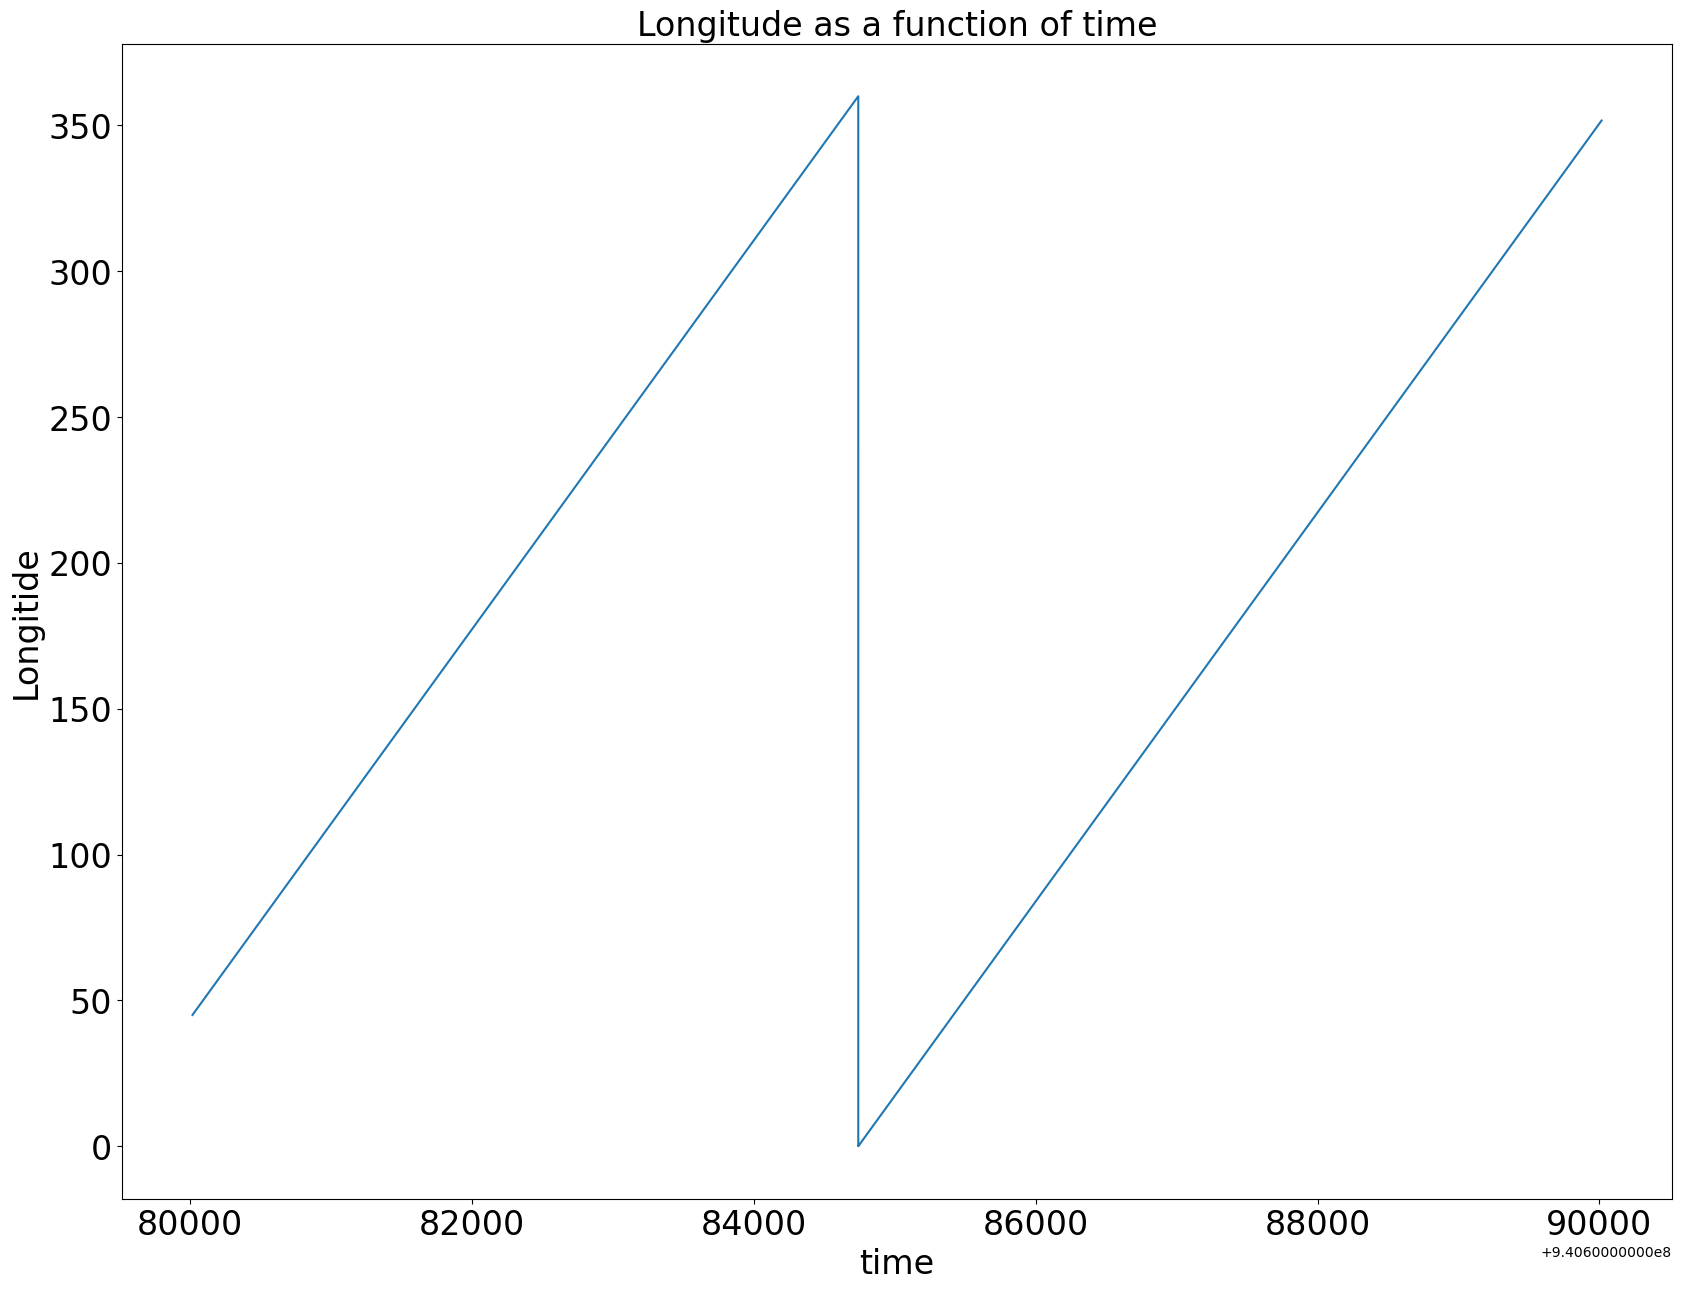

In [25]:

makePlot(time, long, 0, 100000, 1)
plt.xlabel("time", fontsize = 24)
plt.ylabel("Longitide", fontsize = 24)
plt.title("Longitude as a function of time", fontsize = 24);

The above plot show the first 100,000 longitude measurements made as a function of time. From this plot it is clear that the longitude of the orbit of the satellite changes at a constant rate. 

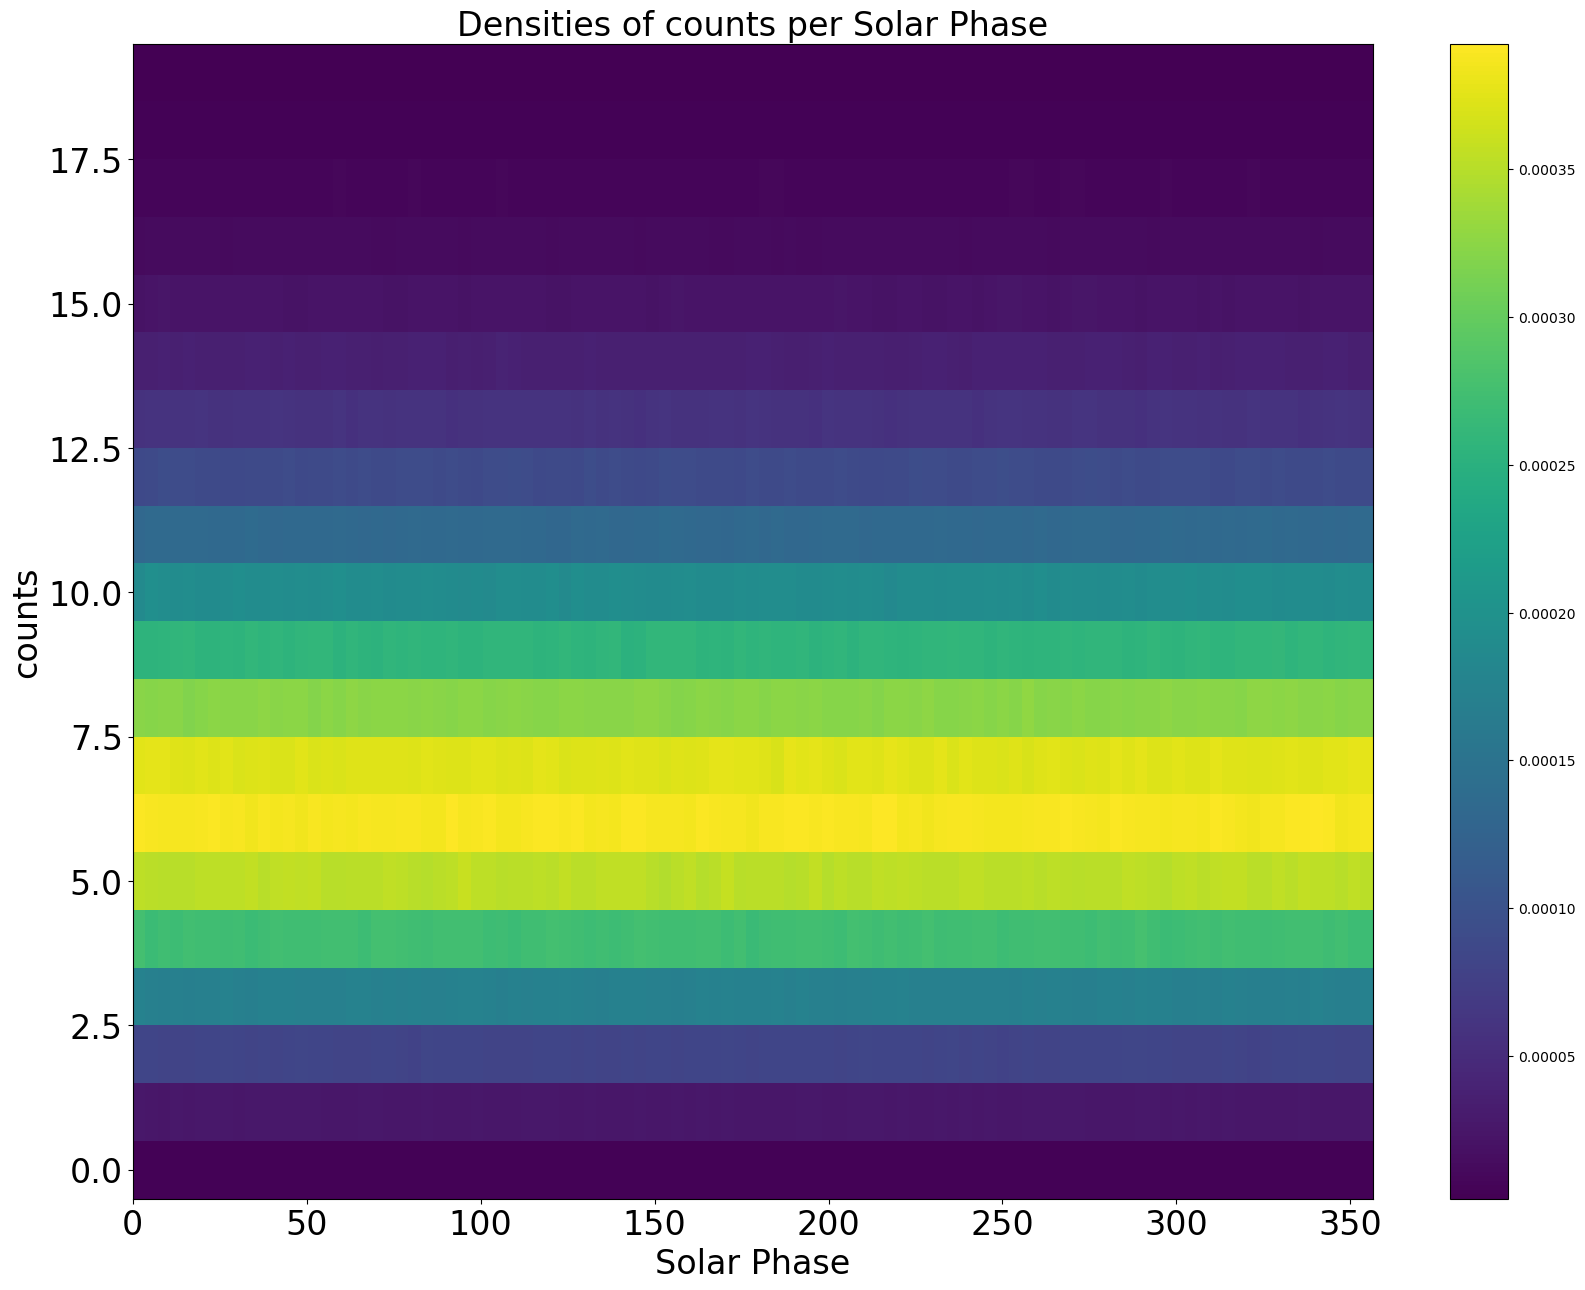

In [11]:
def plotHist2d(x, y, bins):
    plt.tick_params(labelsize = 24)
    
    
    plt.hist2d(x, y, bins = bins, density = True );
    plt.colorbar()

xedges = np.arange(0,360,3.6)
yedges = np.arange(-0.5,20.5)

plotHist2d(solarPhase[0:-1], counts[0:-1], [xedges, yedges])
plt.xlabel("Solar Phase", fontsize = 24)
plt.ylabel("counts", fontsize = 24)
plt.title("Densities of counts per Solar Phase", fontsize = 24);

The above shows the count densities in a 3.6 degree interval of solar phase. The above histogram tries to plot the first two rotations around the earth. 

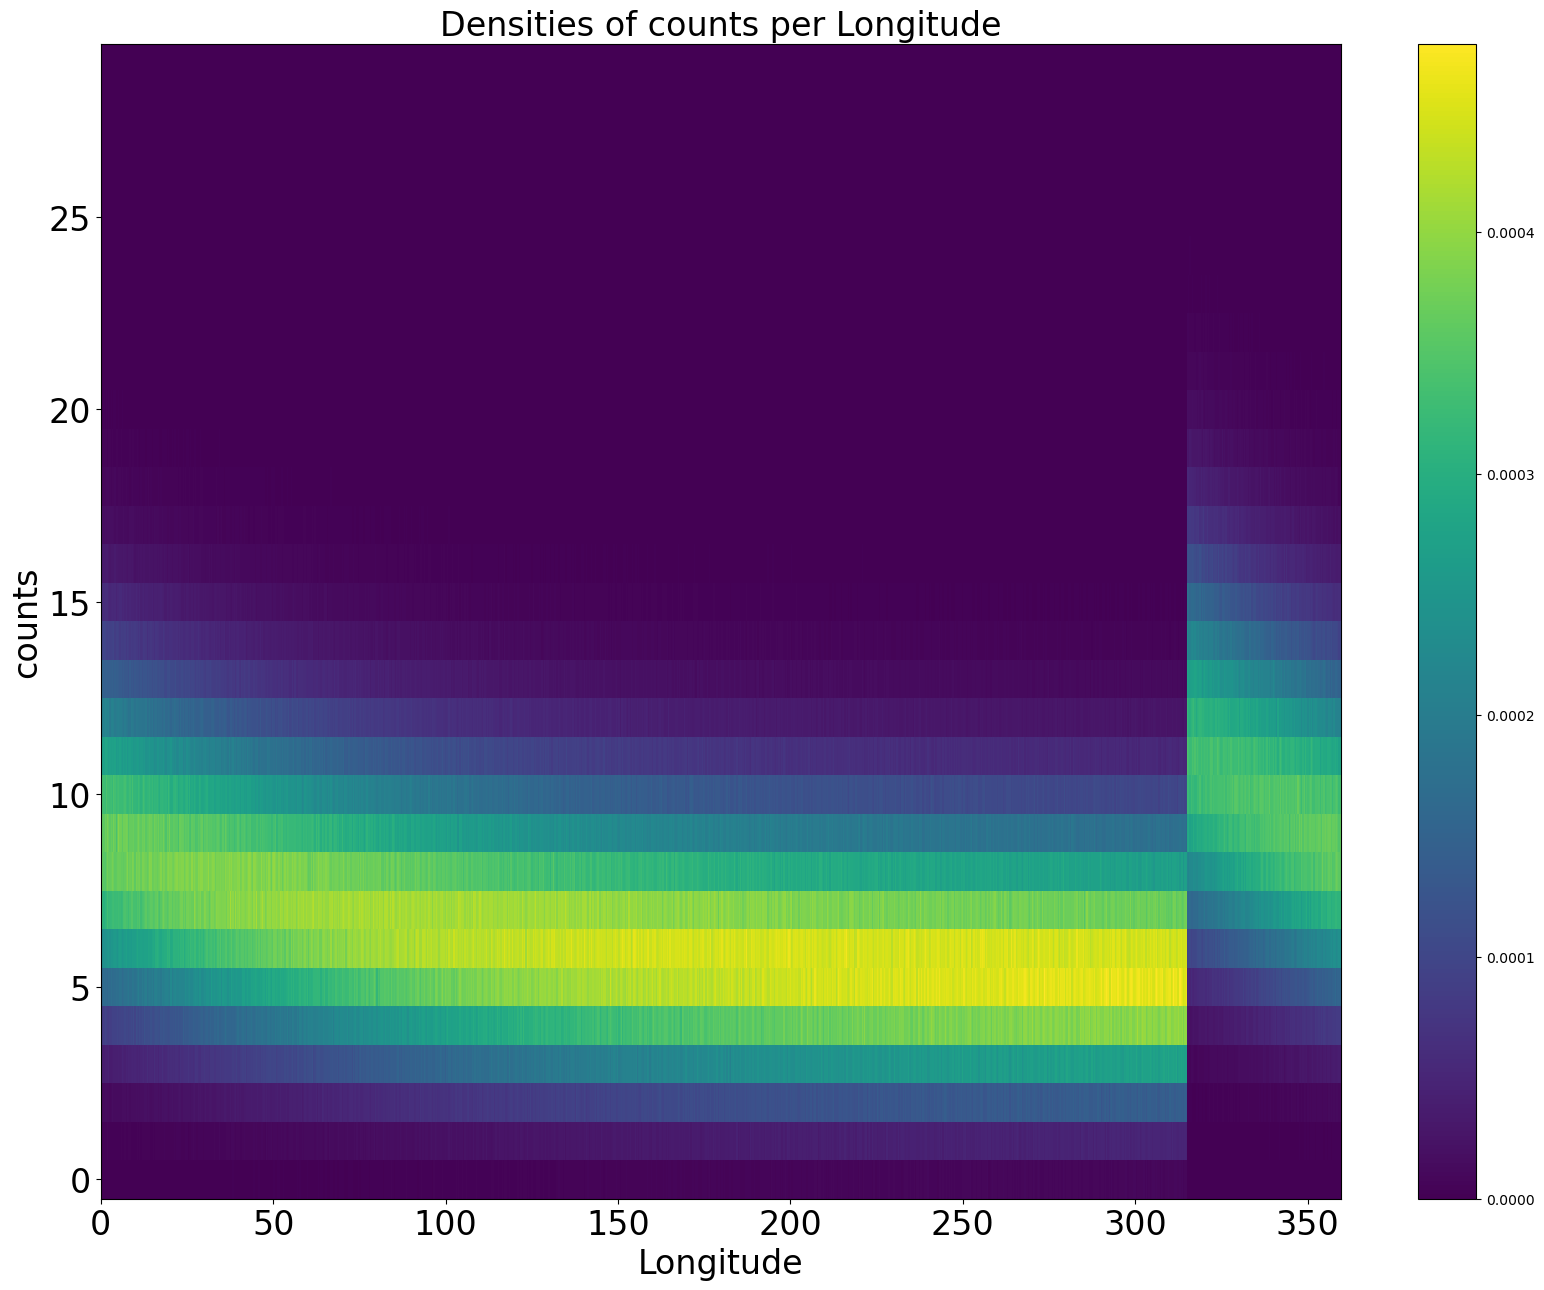

In [12]:
xedges = np.arange(0,360,0.36)
yedges = np.arange(-0.5,30.5)

plotHist2d(long[0:-1], counts[0:-1], [xedges, yedges])
plt.xlabel("Longitude", fontsize = 24)
plt.ylabel("counts", fontsize = 24)
plt.title("Densities of counts per Longitude", fontsize = 24);

This graph shows the number count density per 3.6 degree intervals of longitude. Again, this plot shows that there is some consistent feature around 320 degrees of longitude. 


3) Create a model for the background that includes time dependence. Compare your model to the data. How good is the model for the background?

To create a model I need to know how the mean of my data moves as a function of longitide. Then I can use regression tools to make a model of the background as a function of longitude and then substitue the function for longitude as a function of time. 

In [31]:
newdex = np.array([long - 315, counts])

In [32]:
for i,j in enumerate(newdex[0,:]):
    if j < 0:
        newdex[0,i] = j + 360

In [54]:
bins = 1000
H, xedges, yedges,= np.histogram2d(newdex[0,:], newdex[1,:], bins = [bins, 30])

H = H.T

In [55]:
weights = np.arange(1,31)
means = []
for i in range(len(H[0,:])):
    means.append(sum(H[:,i]*weights)/sum(H[:,i]))


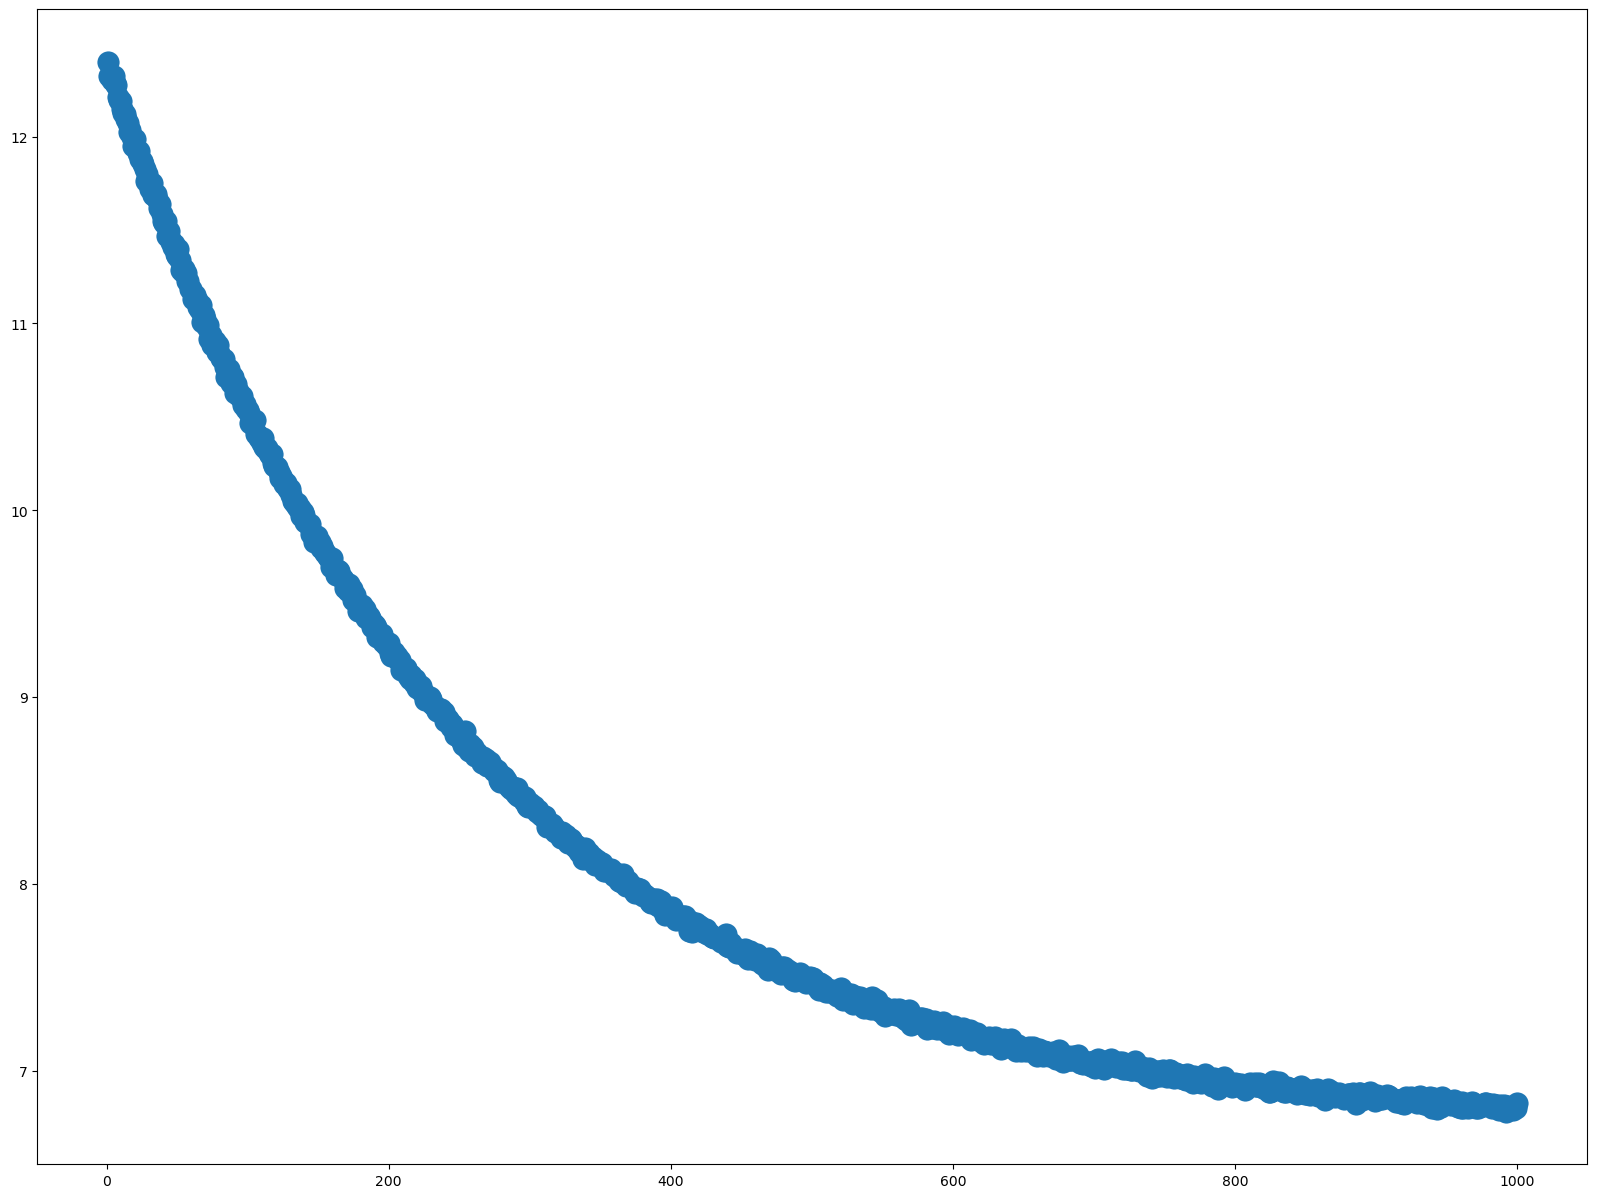

In [56]:
plt.scatter(np.arange(1, bins+1), means, linewidth = 10)

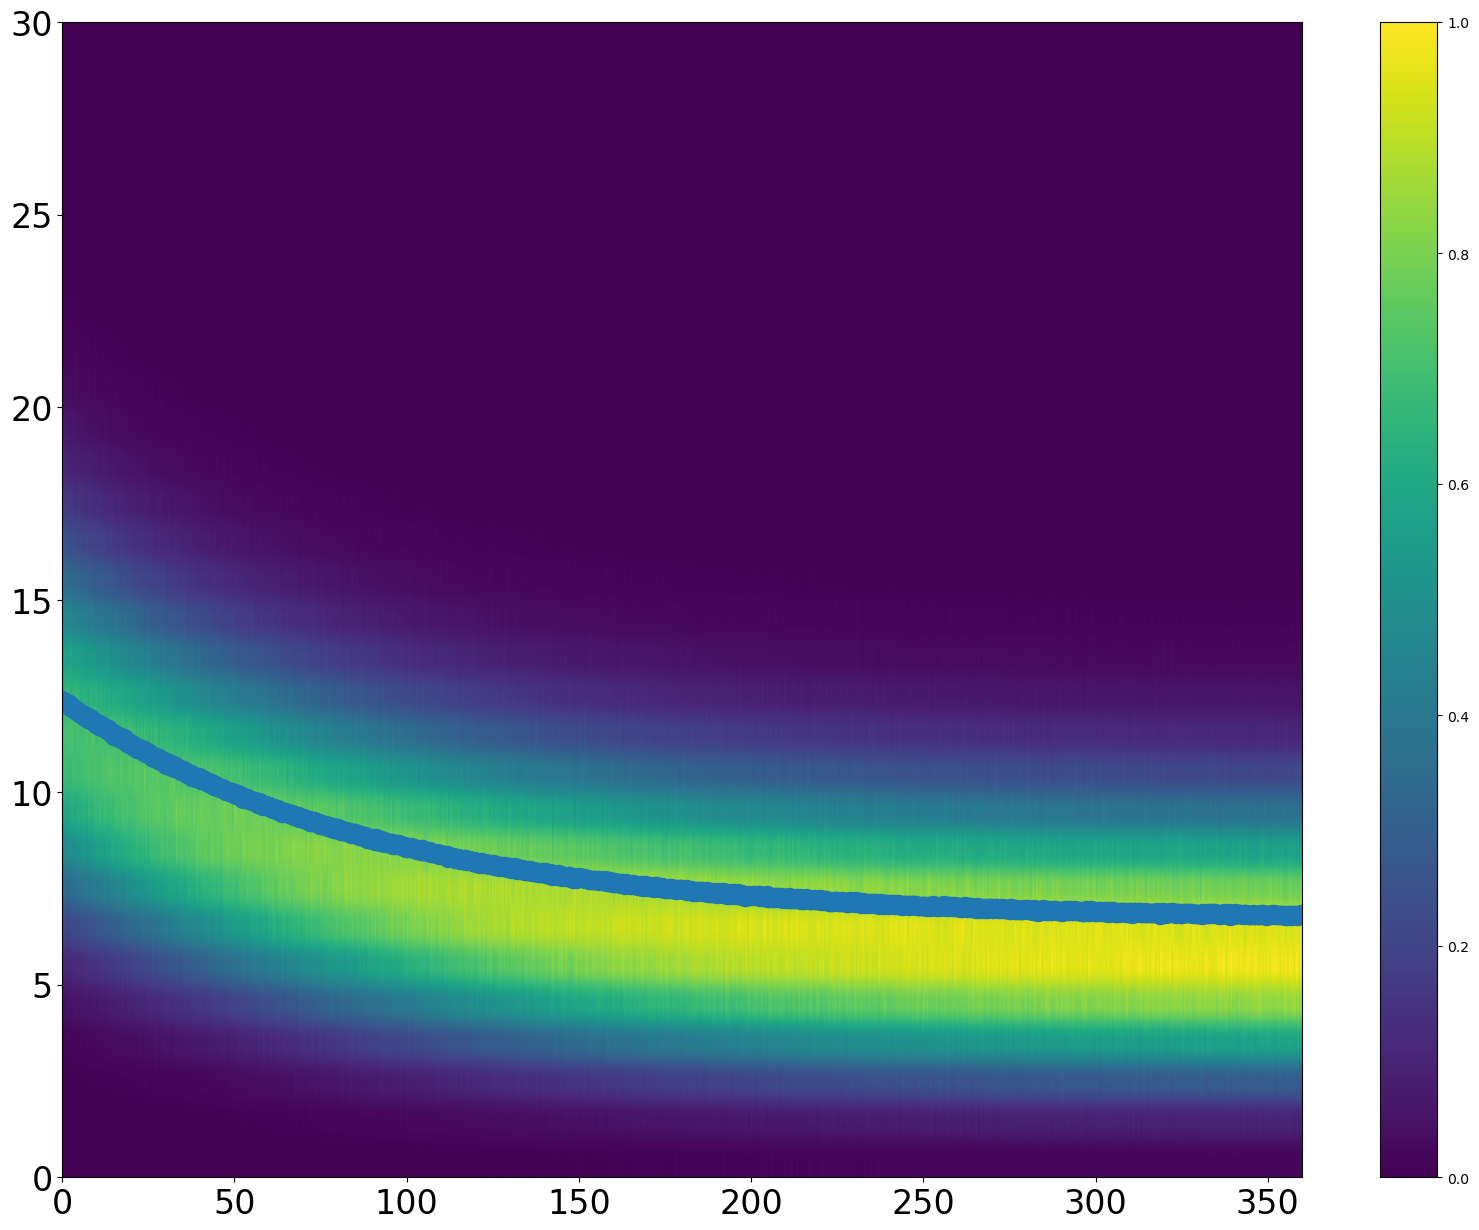

In [57]:
plt.tick_params(labelsize = 24)
plt.imshow(H, aspect ='auto', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.scatter(np.arange(0,360,360/bins), means, linewidth = 8)
plt.colorbar()


In [58]:
def function(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = scipy.optimize.curve_fit(function, np.arange(0,360,360/bins), means)

<ipython-input-58-bf8a77c9b0ba>:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


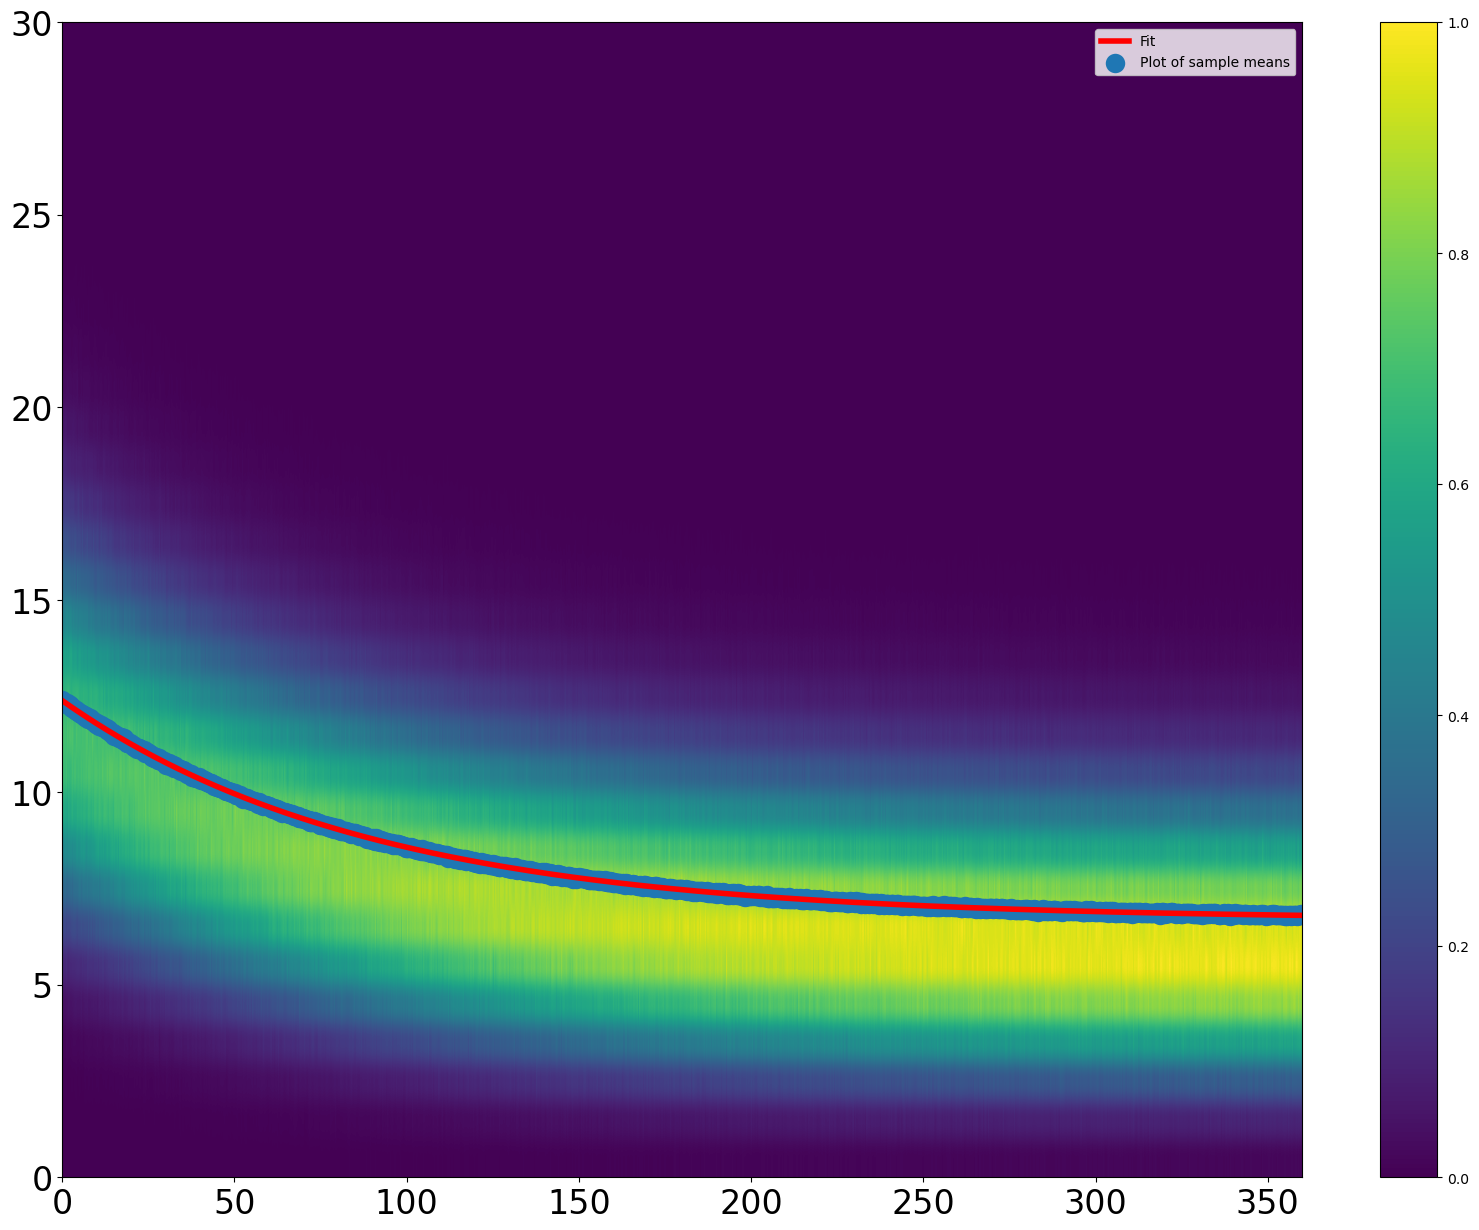

In [60]:
plt.tick_params(labelsize = 24)
plt.imshow(H, aspect ='auto', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.scatter(np.arange(0,360,360/bins), means, linewidth = 8, label = "Plot of sample means")
plt.colorbar()
plt.plot(np.arange(0, 360, 360/bins),
         function(np.arange(0, 360, 360/bins), popt[0], popt[1], popt[2]),
         linewidth = 4, color = 'r', label = "Fit")
plt.legend()

Now that I have parameters and a function that matches the data I need to insert some time dependence into my function. We know that the longitude oscillates periodically. One entire orbital phase corresponds to an entire orbit, therefore setting t = 0 to the beginning of the orbit or when long = 0, and tfinal = 360 gives some way to measure the counts on the satellite as a function of time 

In [61]:
times0 = np.where(long == 0)
time[times0[0][1]]-time[times0[0][0]]

IndexError: index 1 is out of bounds for axis 0 with size 0

In [62]:
def long(t):
    return (360/5400)*t

In [63]:
def function(t, a, b, c):
    return a * np.exp(-b * long(t)) + c

popt, pcov = scipy.optimize.curve_fit(function, np.arange(0,5400,5400/bins), means)

<ipython-input-63-741c2e0cd8a4>:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * long(t)) + c


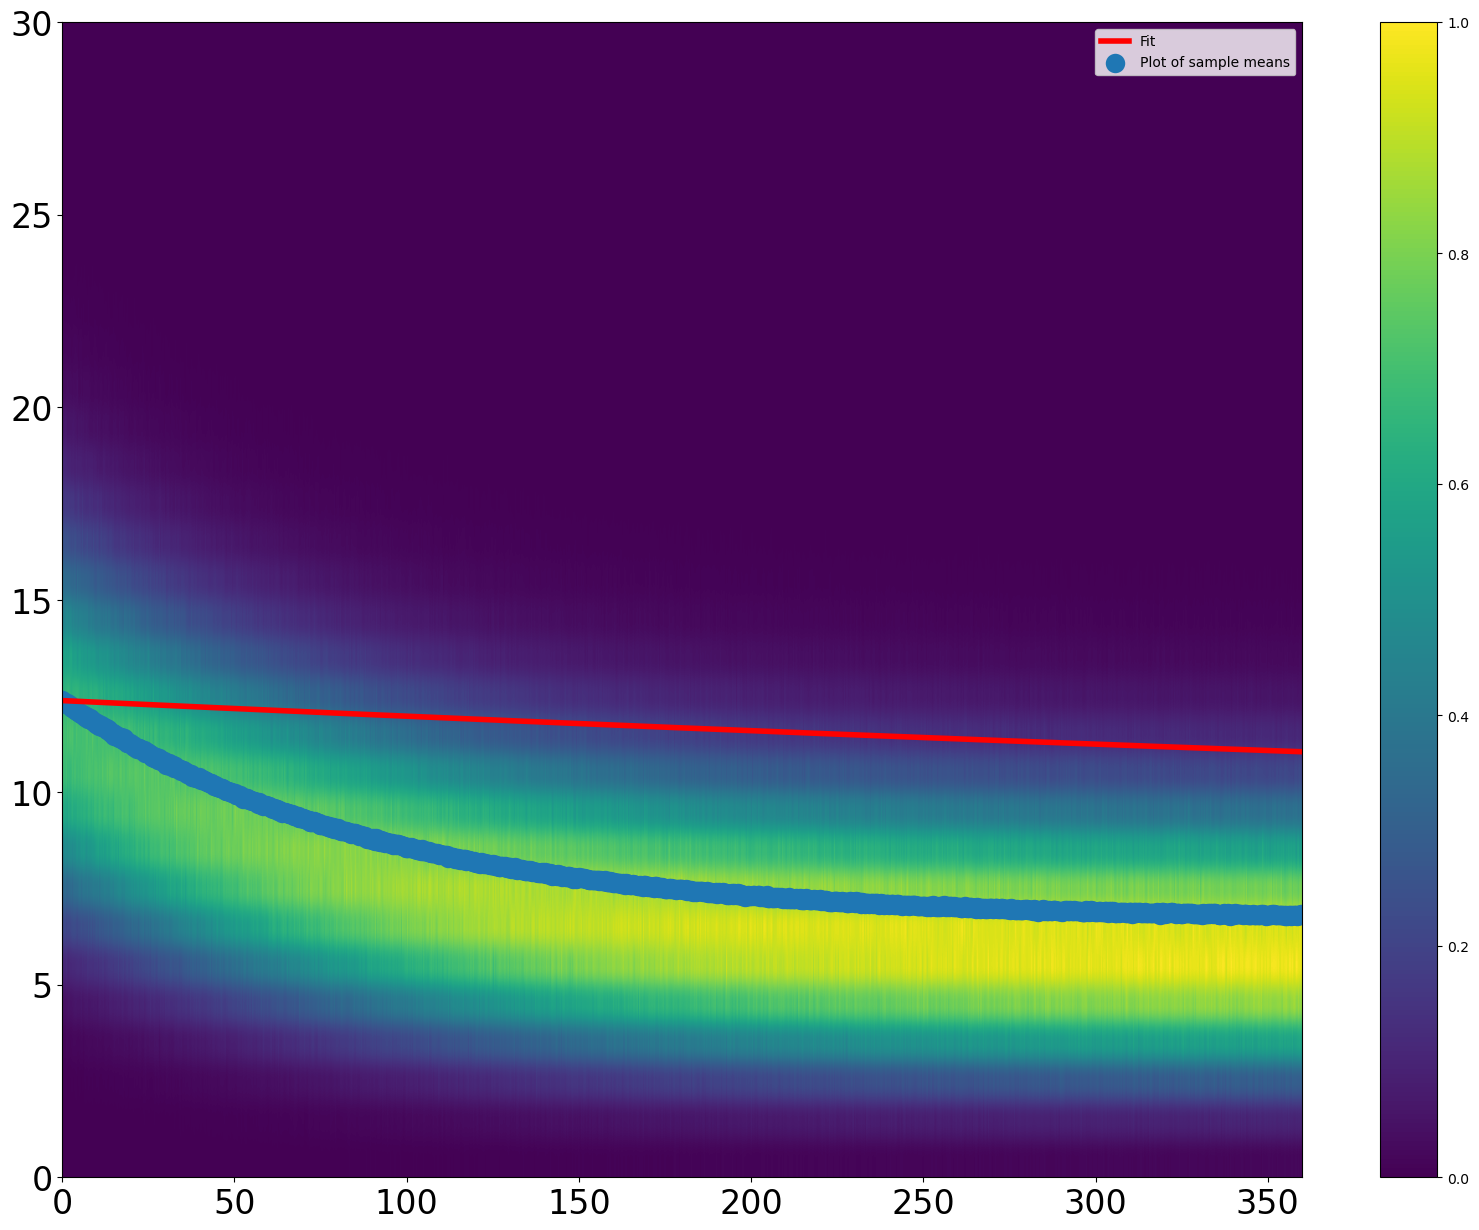

In [64]:
plt.tick_params(labelsize = 24)
plt.imshow(H, aspect ='auto', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.scatter(np.arange(0,360,360/bins), means, linewidth = 8, label = "Plot of sample means")
plt.colorbar()
plt.plot(np.arange(0, 360, 360/bins),
         function(np.arange(0, 360, 360/bins), popt[0], popt[1], popt[2]),
         linewidth = 4, color = 'r', label = "Fit")
plt.legend()

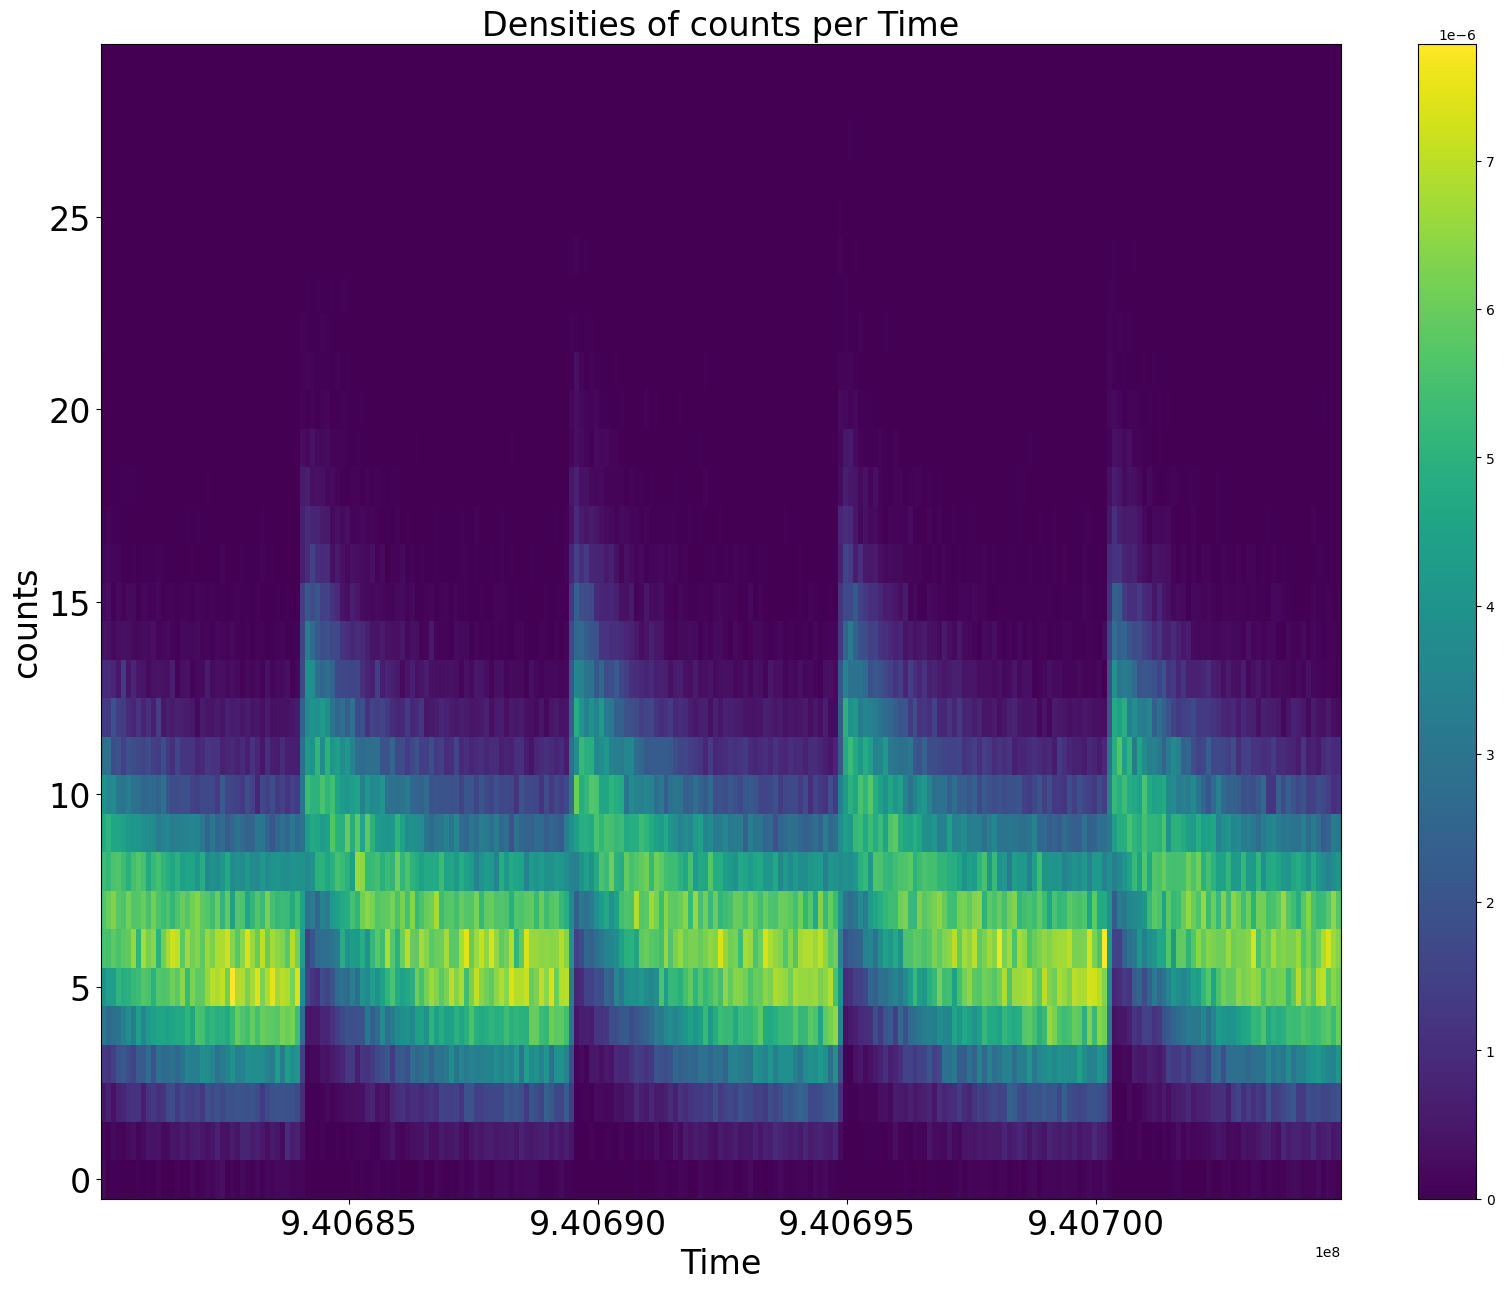

In [26]:
xedges = time[0:250000:1000]
yedges = np.arange(-0.5,30.5)

plotHist2d(time[0:250000], counts[0:250000], [xedges, yedges])
plt.xlabel("Time", fontsize = 24)
plt.ylabel("counts", fontsize = 24)
plt.title("Densities of counts per Time", fontsize = 24);

The above plot shows that the number of counts as a function of time for intervals of 100 seconds. 
The signal is indeed contaminated


## Problem 2

In [22]:
# Part 1
images = h5py.File('images.h5', 'r') #Import the file
image1 = np.array(images.get('image1')) # import the data into an array variable using the get method
imageStack = np.array(images.get('imagestack'))

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

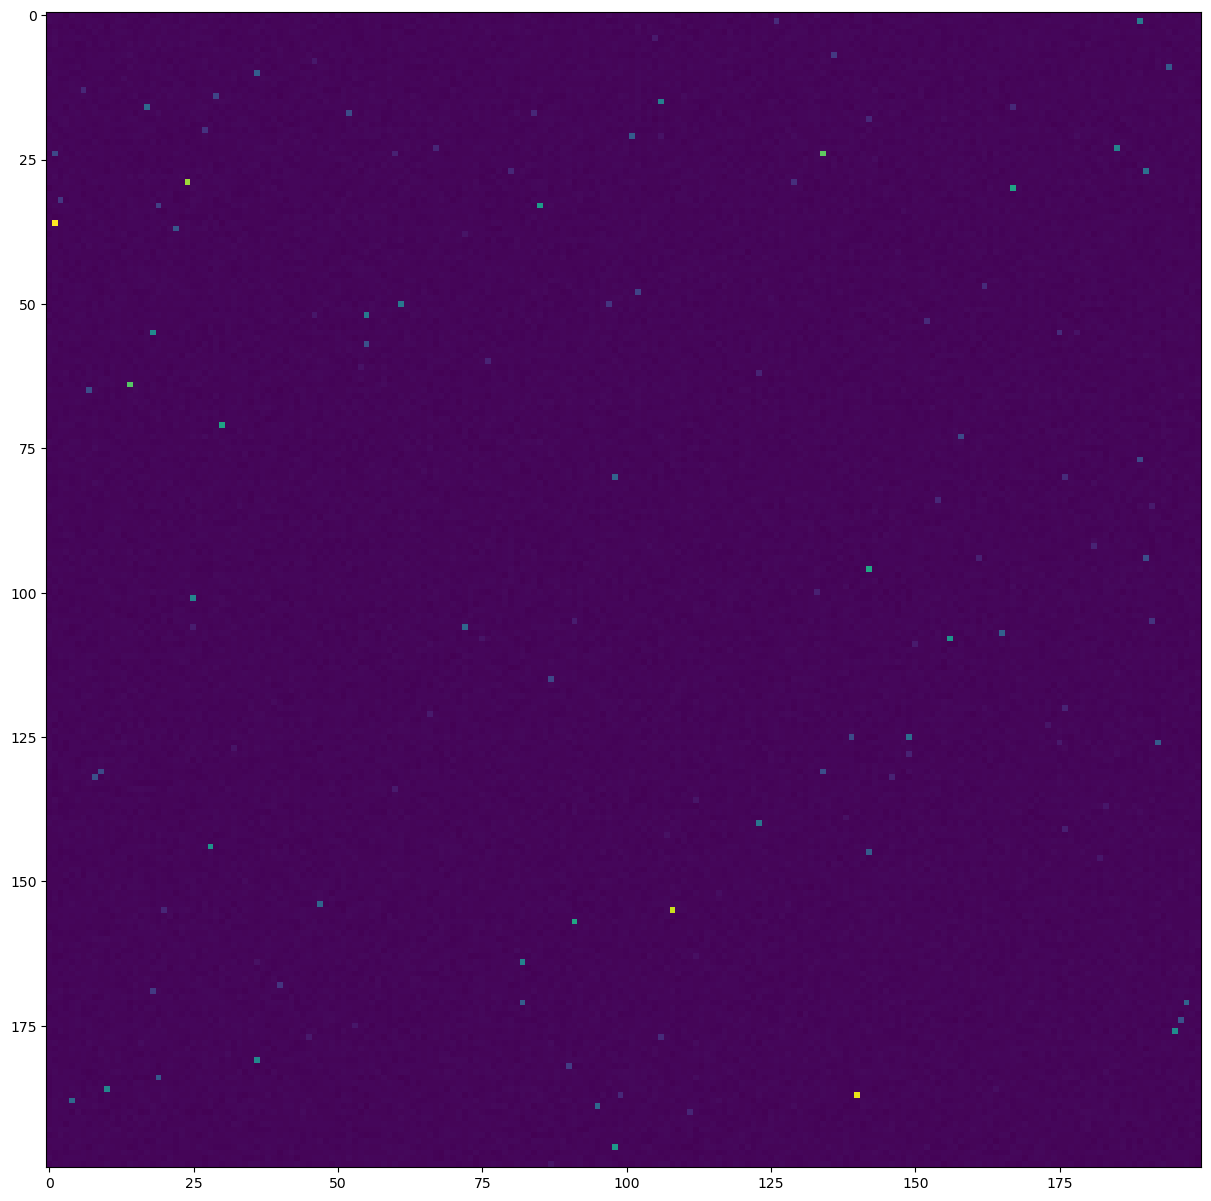

In [23]:
images10 = np.zeros([200,200])
for i in range(9):
    images10 = images10 + imageStack[:,:,i]

plt.imshow(images10)
plt.colorbar